## Xマッチからブキ偏差値を求める

In [1]:
import datetime as dt
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
import seaborn as sns
from scipy.stats import boxcox
from packages.japanize import japanize
import packages.db as db
from packages.i18n import Locale, Translator
import packages.image as image
import packages.definitions as d
import packages.utils as u
import packages.visualize as v

locale = Locale.JA
lobby = d.Lobby.XMATCH
date_from = dt.date(2023, 6, 1)
date_to = dt.date(2023, 6, 8)
battles = db.load_battles(lobby=lobby, date_from=date_from, date_to=date_to)

バトル数: 6687


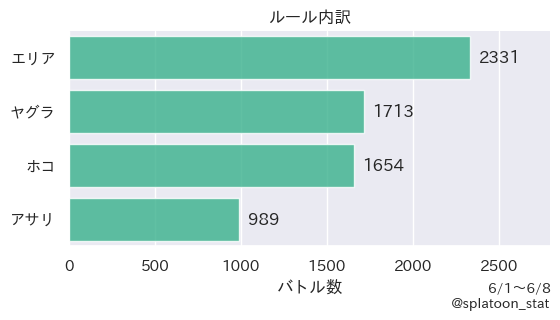

パワー不明バトル数: 1496


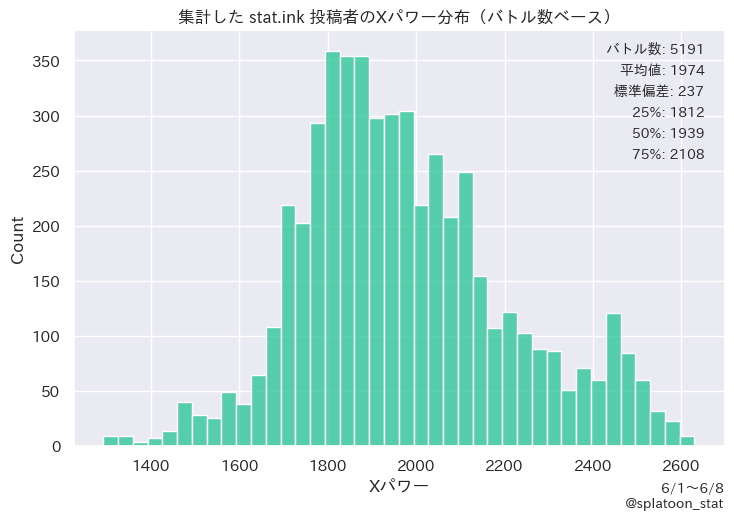

In [2]:
v.xmatch_mode_breakdown(battles=battles, locale=locale)
v.xmatch_power_distribution(battles=battles, locale=locale)

In [3]:
players = u.to_players(battles)

### ブキ統計値を求める

- ブキ使用率
- ブキ使用者の平均Xパワー

In [4]:
usage = players.groupby("mode")["weapon"].value_counts(normalize=True).to_frame("usage")
power = players.groupby(["mode", "weapon"])["power"].mean().to_frame("power")

def standardize(series: pd.Series) -> pd.Series:
    return (series - series.mean()) / series.std()

weapon_stat = pd.concat([usage, power], axis=1)
weapon_stat["usage-bc"] = weapon_stat.groupby("mode")["usage"].transform(lambda x: boxcox(x)[0])
weapon_stat["usage-z"] = weapon_stat.groupby("mode", group_keys=False)["usage-bc"].apply(standardize)
weapon_stat["power-z"] = weapon_stat.groupby("mode", group_keys=False)["power"].apply(standardize)

k_coef = 0.45
theta = np.pi / 2 * k_coef
vec_strength = np.array([np.cos(theta), np.sin(theta)])

def calc_dot(series: pd.Series) -> float:
    vec_weapon = np.array([series["usage-z"], series["power-z"]])
    return np.dot(vec_weapon, vec_strength)

weapon_stat["strength"] = weapon_stat.apply(calc_dot, axis=1)
weapon_stat["strength-z"] = standardize(weapon_stat["strength"])
weapon_stat["strength-t"] = weapon_stat["strength-z"].map(lambda x: x * 10 + 50)
weapon_stat

usage        power  usage-bc   usage-z  \
mode   weapon                                                            
area   sshooter_collabo      0.053931  1910.987049 -2.192365  2.125223   
       spaceshooter_collabo  0.044493  2004.567839 -2.295509  1.884080   
       sharp_neo             0.041307  2005.646516 -2.334272  1.793455   
       wakaba                0.040449  1915.716909 -2.345112  1.768111   
       sharp                 0.033462  2028.822222 -2.440939  1.544074   
...                               ...          ...       ...       ...   
yagura h3reelgun             0.000834  1972.262500 -3.552467 -1.508434   
       carbon                0.000584  1970.920000 -3.622532 -1.693082   
       l3reelgun             0.000500  2214.220000 -3.651123 -1.768432   
       bucketslosher_deco    0.000167  1937.250000 -3.828659 -2.236305   
       wideroller            0.000167  2056.700000 -3.828659 -2.236305   

                              power-z  strength  strength-z  strength-t  
mode   weapon                                                            
area   sshooter_collabo     -0.698879  1.162146    1.196544   61.965438  
       spaceshooter_collabo  0.461727  1.732533    1.783813   67.838129  
       sharp_neo             0.475105  1.672310    1.721807   67.218074  
       wakaba               -0.640218  0.928694    0.956181   59.561815  
       sharp                 0.762534  1.669350    1.718759   67.187592  
...                               ...       ...         ...         ...  
yagura h3reelgun            -0.277027 -1.326937   -1.366212   36.337880  
       carbon               -0.297906 -1.480904   -1.524736   34.752639  
       l3reelgun             3.485934  0.919207    0.946414   59.464137  
       bucketslosher_deco   -0.821547 -2.234051   -2.300175   26.998248  
       wideroller            1.036158 -1.027569   -1.057983   39.420173  

[358 rows x 8 columns]

### 可視化する

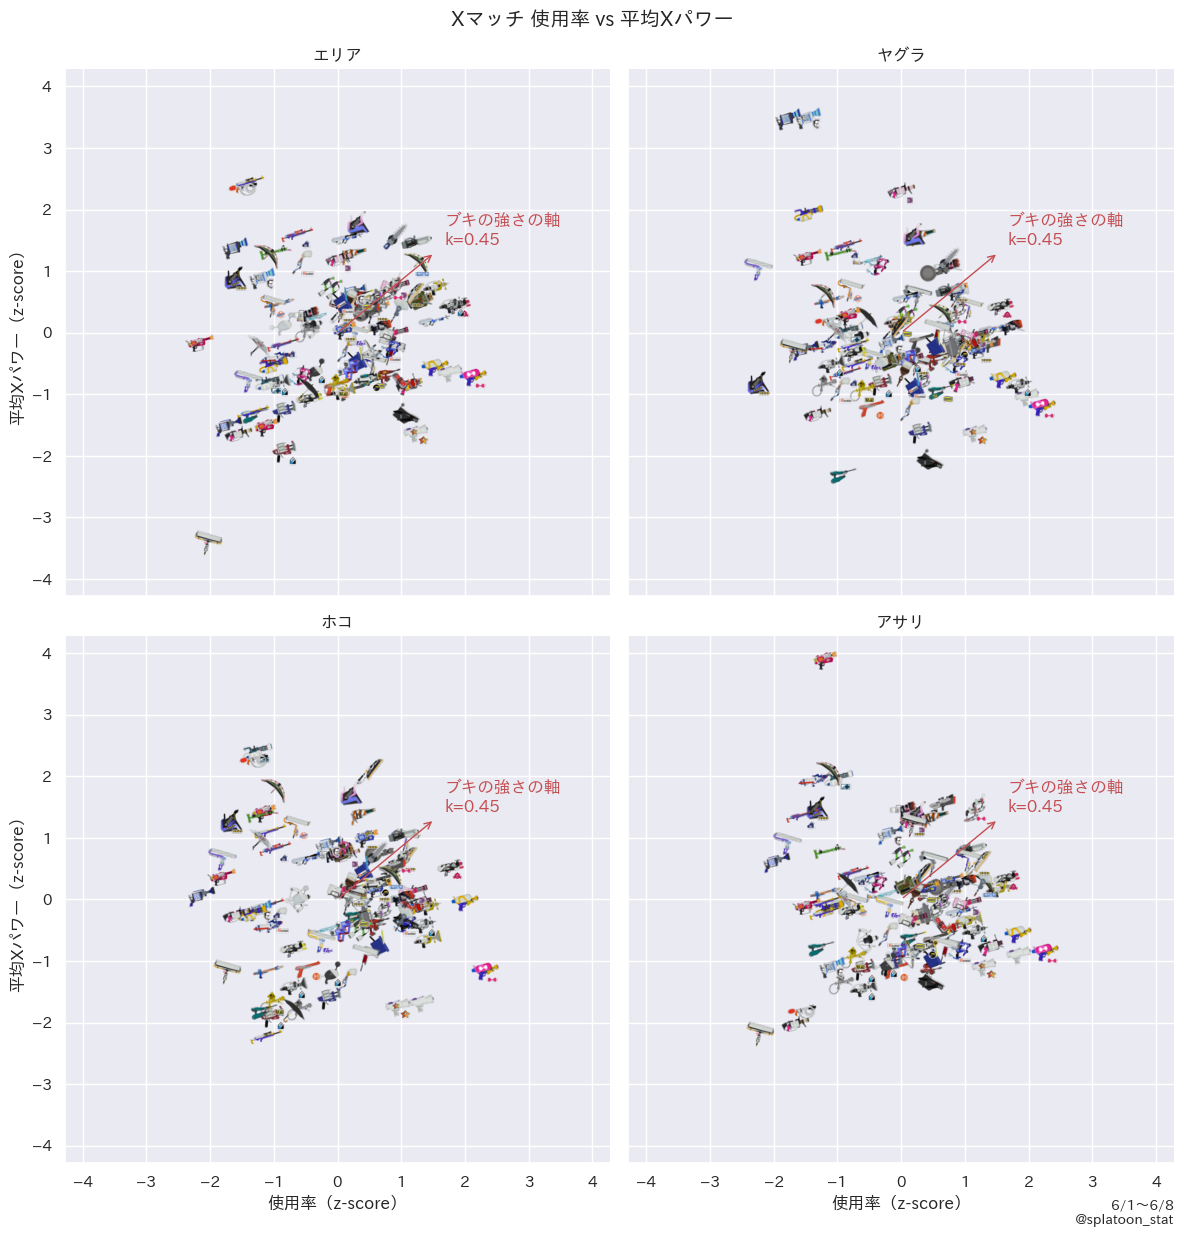

In [5]:
sns.set_theme()
japanize()

i18n = Translator(locale)
i18n.add("usage", "使用率（z-score）", "Usage (z-score)")
i18n.add("power", "平均Xパワー（z-score）", "X Power Avg. (z-score)")
i18n.add("vector", "ブキの強さの軸", "Assumed axis\nof weapon strength")
i18n.add("title", "${lobby} 使用率 vs 平均Xパワー", "Usage vs X Power Avg. in ${lobby}")

value_range = max(weapon_stat[["usage-z", "power-z"]].abs().max().max() * 1.1, 3)

g = sns.relplot(
    data=weapon_stat,
    x="usage-z",
    y="power-z",
    col="mode",
    col_wrap=2,
    col_order=d.MODE_ORDER,
    marker="",
    height=6,
)
g.fig.suptitle(
    i18n.t("title", lobby=i18n.t(lobby.value)),
    verticalalignment="bottom",
    y=1,
)
g.set(
    xlabel=i18n.t("usage"),
    ylabel=i18n.t("power"),
    xlim=(-value_range, value_range),
    ylim=(-value_range, value_range),
)

for i, ax in enumerate(g.axes):
    mode = d.MODE_ORDER[i]
    ax.set(title=i18n.t(mode))

    for _, row in weapon_stat.loc[mode].iterrows():
        weapon = row.name
        xvalue = row["usage-z"]
        yvalue = row["power-z"]
        image_path = image.get_image_path(weapon)
        im = plt.imread(image_path)
        img = OffsetImage(im, zoom=0.65)
        img.image.axes = ax
        ab = AnnotationBbox(img, (xvalue, yvalue), frameon=False, pad=0)
        ax.add_artist(ab)

    # ブキの強さの軸のベクトルを表示する
    ax.annotate("", (0, 0), xytext=[x * 2 for x in vec_strength], color="r", arrowprops=dict(arrowstyle="<-", connectionstyle="arc3", color="r"))
    ax.annotate(f"{i18n.t('vector')}\nk={k_coef}", (0, 0), xytext=[x * 2.2 for x in vec_strength], color="r")

    if i == 3:
        u.credit(ax, g.fig, i18n.t_data_duration(battles))

plt.show()

In [6]:
strength_map = weapon_stat.reset_index().pivot(index="weapon", columns="mode", values="strength-t").reindex(d.MODE_ORDER, axis=1)
strength_map["mean"] = strength_map.mean(axis=1)
strength_map = strength_map.sort_values("mean", ascending=False)
strength_map


mode,area,yagura,hoko,asari,mean
weapon,,,,,
spaceshooter_collabo,67.838129,65.128247,67.398899,65.288207,66.413371
kugelschreiber,69.732162,60.872202,65.243253,64.254233,65.025463
quadhopper_white,61.511881,58.857569,61.784034,68.822824,62.744077
bucketslosher,64.299805,62.158250,63.039029,61.356166,62.713313
sharp,67.187592,59.097885,60.354873,63.306376,62.486682
...,...,...,...,...,...
clashblaster_neo,30.602001,41.856436,29.176965,37.754120,34.847381
h3reelgun,26.395791,36.337880,33.701444,38.793379,33.807123
jetsweeper,31.043370,27.550218,28.929296,35.087437,30.652580


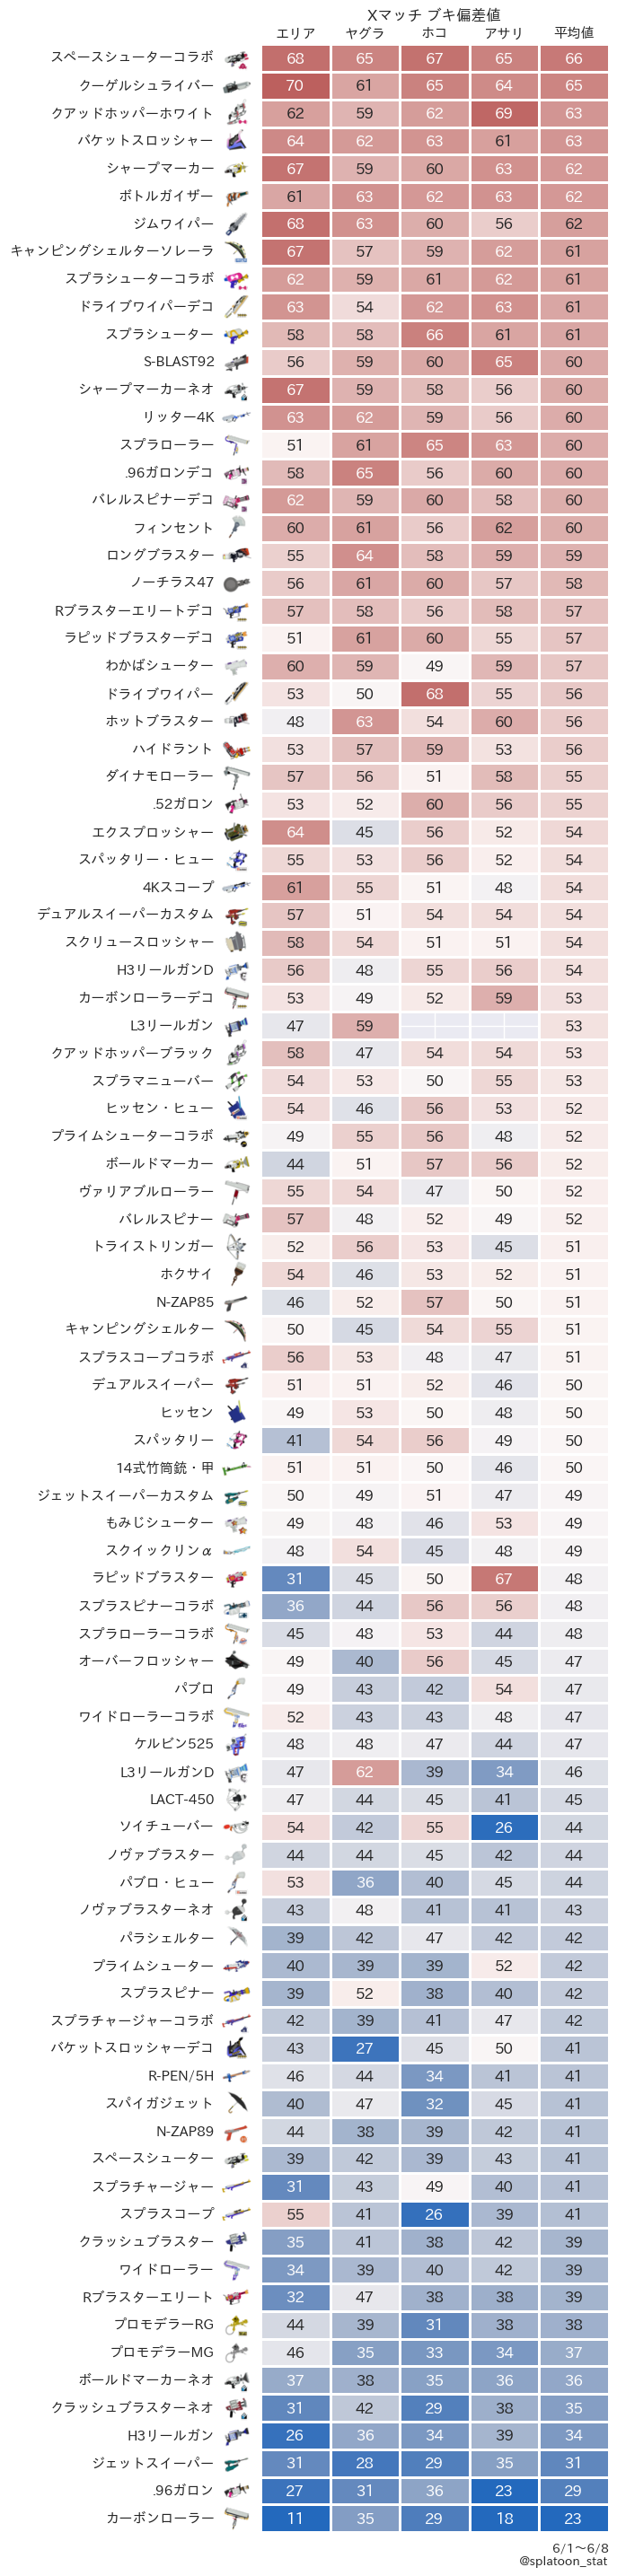

In [7]:
sns.set_theme()
japanize()

i18n = Translator(locale)
i18n.add("strength", "ブキ偏差値", "Usage Strength (t-score)")
i18n.add("title", "${lobby} ブキ偏差値", "Weapon Strehgth (t-score) in ${lobby}")

fig, ax = plt.subplots(figsize=(5, len(strength_map.index) * 0.4))
sns.heatmap(
    strength_map,
    annot=True,
    fmt=".0f",
    cbar=False,
    cmap=sns.color_palette("vlag", as_cmap=True),
    center=50,
    vmin=50-25,
    vmax=50+25,
    linewidths=2,
    ax=ax,
)

xkeys, ykeys = u.get_ax_ticklabels(ax)
xticklabels = [i18n.t(x) for x in xkeys]
yticklabels = [i18n.t(x) for x in ykeys]

ax.xaxis.tick_top()
ax.xaxis.set_label_position("top")
ax.tick_params(length=0)

ax.set(
    title=i18n.t("title", lobby=i18n.t(lobby.value)),
    xlabel="",
    ylabel="",
    xticklabels=xticklabels,
)
ax.yaxis.set_ticklabels(yticklabels, x=-0.12)

for i, key in enumerate(ykeys):
    image_path = image.get_image_path(key)
    img = OffsetImage(plt.imread(image_path), zoom=.65)
    img.image.axes = ax
    ab = AnnotationBbox(img, (0, 0), xybox=(-0.35, i + 0.5), frameon=False)
    ax.add_artist(ab)

u.credit(ax, fig, i18n.t_data_duration(battles), .3)

plt.show()